In [57]:
from osgeo import gdal
import geopandas
from geopandas import sjoin
import folium
from ipyleaflet import Map
import matplotlib.pyplot as plt
from pyproj import CRS

In [41]:
data=geopandas.read_file("data_aurin/suburbs.json")
# railways=geopandas.read_file("data_aurin/railways.json")
melbourne_city=["CARLTON", "DOCKLANDS", "EAST MELBOURNE", "KENSINGTON", "MELBOURNE", "NORTH MELBOURNE",
                "PARKVILLE", "PORT MELBOURNE", "SOUTHBANK", "SOUTH YARRA", "WEST MELBOURNE"]
meoblurne_city = melbourne_city.sort()
data2 = data[data["name"].isin(melbourne_city)]
data2 = data2.sort_values(by="name")


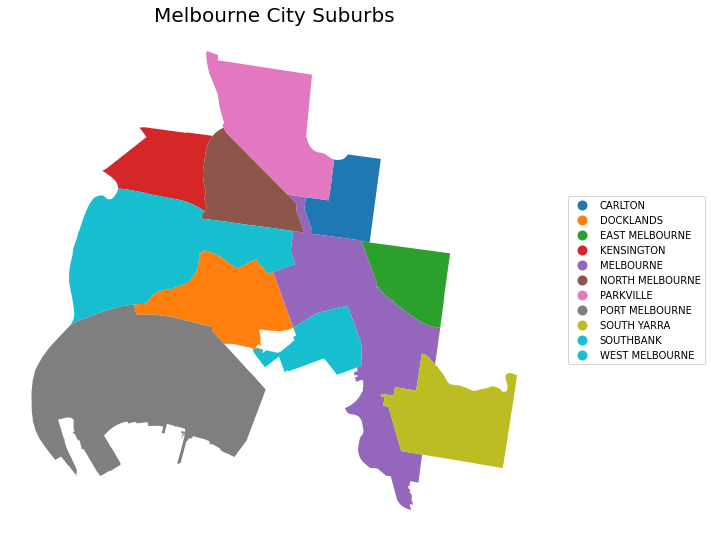

In [71]:
fig, ax = plt.subplots(1, figsize=(10, 20))
data2.plot(ax=ax, column="name", legend=True, legend_kwds={"loc" : 'center left'})
leg = ax.get_legend()
leg.set_bbox_to_anchor((1.04, 0.5))
plt.axis('off')
plt.tight_layout()
plt.title("Melbourne City Suburbs", fontsize=20)
plt.savefig("figures/suburbs.png", dpi=100)

In [83]:
agg_data ={}
for sub in melbourne_city:
    agg_data[sub] = {}
def aggregate(file_path, structure, suburbs, aggregation):
    data = geopandas.read_file(file_path)
    for suburb in suburbs:
        total = len(sjoin(data2[data2.name == suburb], data, how="left"))
        aggregation[suburb][structure] = total

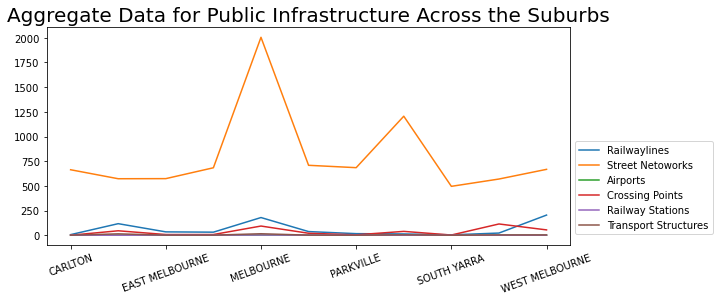

In [84]:
# aggregating the railway lines
aggregate("data_aurin/railways.json", "Railwaylines", melbourne_city, agg_data)

# aggregating street networks
aggregate("data_aurin/streets.json", "Street Netoworks", melbourne_city, agg_data)

# aggregating airports
aggregate("data_aurin/airports.json", "Airports", melbourne_city, agg_data)

# aggregating crossing points
aggregate("data_aurin/crossing_pts.json", "Crossing Points", melbourne_city, agg_data)

# aggregating railway stations
aggregate("data_aurin/railway_stns.json", "Railway Stations", melbourne_city, agg_data)

# aggregating transport structures
aggregate("data_aurin/transport_structures.json", "Transport Structures", melbourne_city, agg_data)

# data frame of aggregates
import pandas as pd

fig, ax = plt.subplots(1, figsize=(10, 4))
df_agg = pd.DataFrame(agg_data).transpose()
df_agg.plot(ax=ax)
leg = ax.get_legend()
leg.set_bbox_to_anchor((1, 0.5))
plt.xticks(rotation=20)
plt.tight_layout()
plt.title("Aggregate Data for Public Infrastructure Across the Suburbs", fontsize=20)
plt.savefig("figures/aggregate.png", dpi=150)


In [59]:
#create and display map

mel_latlong = [-37.840935, 144.946457]
m = folium.Map(location=mel_latlong,tiles = 'cartodbpositron', zoom_start=12, control_scale=True)
data=data2[["geometry", "id", "name"]] #only get the needed data



In [79]:
for _, r in data.iterrows():
    # Without simplifying the representation of each borough,
    # the map might not be displayed
    sim_geo = geopandas.GeoSeries(r['geometry']).simplify(tolerance=0.001)
    geo_j = sim_geo.to_json()
    geo_j = folium.GeoJson(data=geo_j,
                           style_function=lambda x: {'fillColor': 'red'})
    folium.Popup(r['name']).add_to(geo_j)
    geo_j.add_to(m)

# Project to NAD83 projected crs
data = data.to_crs(epsg=2263)

# Access the centroid attribute of each polygon
data['centroid'] = data.centroid

# Project to WGS84 geographic crs

# geometry (active) column
data = data.to_crs(epsg=4326)

# Centroid column
data['centroid'] = data['centroid'].to_crs(epsg=4326)

for _, r in data.iterrows():
    lat = r['centroid'].y
    lon = r['centroid'].x
    folium.Marker(location=[lat, lon]).add_to(m)

In [80]:
m